# First SSVEP dataset


**labels:**

0 - no flickering

1 2 3 4 - for the boxes


**id label alphabetical:**

0 - alebs

1 - barlo

2 - yagmur

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate
import scipy.fftpack
from scipy.signal import butter, lfilter, filtfilt


from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC

from filtering_cca import * #cca_corrs


%matplotlib inline

## Load Data

In [2]:
# load and sort the paths
path = '../data/raw/'
sampling_rate = 128

fnames = glob(path+'*.csv') # get paths and save them
fnames.sort()
fnames

['../data/raw/alebs-2-record.csv',
 '../data/raw/alebs-record.csv',
 '../data/raw/barlo-2-record.csv',
 '../data/raw/barlo-record.csv',
 '../data/raw/yagmur-record.csv']

In [3]:
col_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'label']
data = {}
for i, name in enumerate(fnames):
    data[i] = pd.read_csv(name, names=col_names)
    data[i]['id'] = i
    
data[1].tail()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,label,id
68155,4133.3,4111.8,4103.6,4100.0,4101.4,4106.3,4109.9,4102.3,4113.8,4104.2,4115.3,4079.6,4107.1,4122.3,0,1
68156,4116.5,4102.1,4102.4,4099.6,4109.2,4095.3,4115.5,4095.5,4106.2,4117.6,4091.5,4074.4,4101.4,4102.8,0,1
68157,4138.3,4110.1,4106.0,4102.3,4107.3,4088.1,4113.8,4098.1,4106.4,4117.1,4099.2,4087.2,4102.3,4123.7,0,1
68158,4154.0,4125.0,4106.3,4099.0,4099.5,4094.6,4111.3,4107.9,4119.9,4109.2,4118.3,4100.3,4101.7,4144.1,0,1
68159,4122.4,4105.1,4100.5,4096.7,4102.2,4104.9,4114.4,4108.7,4124.2,4115.9,4109.6,4086.0,4097.4,4112.4,0,1


In [4]:
data_all = pd.DataFrame()

for i in np.arange(0,3):
    data_all = pd.concat([data_all, data[i]], axis=0, ignore_index=True)

## Epochs

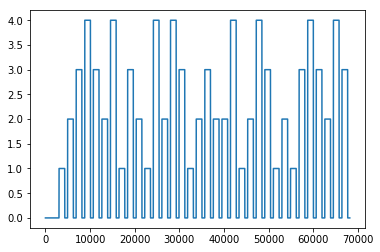

In [5]:
yagmur = data[1] #0 aleks, 1 carlo, 2 yagmur
plt.plot(yagmur.label)

### Get indexes of on and off of each stimuli

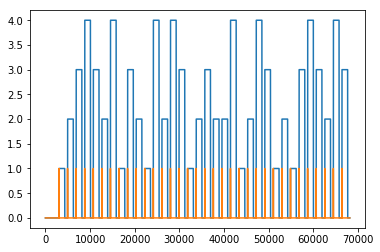

In [6]:
threshold = 0.5

idxOFF = np.argwhere(yagmur.label < threshold)
idxON = np.argwhere(yagmur.label > threshold)


x_alwaysON = np.zeros(len(yagmur.index))
x_alwaysON[idxON] = 1

x_turnON = np.roll(x_alwaysON, 1)
x_turnON = x_alwaysON - x_turnON
x_turnON = np.where(x_turnON > 0, x_turnON, 0)

plt.plot(yagmur.label)#x_alwaysON)
plt.plot(x_turnON)
plt.show()

### Get Yagmurs epochs

In [7]:
#picked_electrodes = {'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'}
picked_electrodes = {'AF3', 'F3', 'AF4', 'F4', 'F7', 'F8'}
#picked_electrodes = {'F4'}

data_electr_filt = np.zeros((yagmur.shape[0], len(picked_electrodes)))


for n, elec in enumerate(picked_electrodes):
    data_electr_filt[:,n] = yagmur[elec]

data_electr_filt.shape

(68160, 6)

In [8]:
N_epoch = 400

epochs = np.zeros((len( np.argwhere(x_turnON) ),N_epoch, data_electr_filt.shape[1])) #34x700x4 
for n, i in enumerate(np.argwhere(x_turnON)):    
    epochs[n,:,:] = data_electr_filt[i[0]+400:i[0]+400+N_epoch,:]
    
epochs_concat = np.zeros((epochs.shape[0]*epochs.shape[2], epochs.shape[1]))
n = epochs.shape[0]
for i in range(epochs.shape[2]):
    epochs_concat[n*i:n*i+n,:] = epochs[:,:,i]

In [9]:
epochs.shape

(34, 400, 6)

### Get Labels
Carlo Labels 1 = empty 2 = 20 Hz 3 = 15 Hz 4 = 10 Hz

In [10]:
labels1 = np.zeros(len(np.argwhere(x_turnON)))
i = 0
for n in np.argwhere(x_turnON):
    labels1[i] = yagmur.label[n]
    i+=1
labels1
y = labels1

### Filter data and get the corr scores

In [107]:
y_est = np.zeros_like(y)
r = np.zeros([34, 3])
for i in range(34):
    X_input = np.squeeze(epochs[i,:,:])
#     r[i,:] = cca_corrs(X_input, 20, 15, 10, sampling_rate)
    r[i,:] = kcca_corrs(X_input, 20, 15, 10, sampling_rate, reg=.1, gausigma=.01, degree=2)
    y_est[i] = np.argmax(r[i,:]) + 2
    


4 = 20 Hz (middle)
1 = 15 Hz (up)
2 = 12 Hz (left)
3 = 8 Hz  (right)

### Estimate the label from the scores
Labels 
1 = empty 2 = 20 Hz 3 = 15 Hz 4 = 10 Hz

In [108]:
np.sum((y-y_est)==0)/34

0.6470588235294118

In [109]:
# simple estimation
np.sum((y[y!=1]-y_est[y!=1]) == 0)/np.sum((y!=1)==True)

0.8148148148148148

In [110]:
print(y)
print(y_est)

[1. 2. 3. 4. 3. 2. 4. 1. 3. 2. 1. 4. 2. 4. 3. 1. 2. 3. 2. 2. 4. 1. 2. 4.
 3. 1. 2. 1. 3. 4. 3. 2. 4. 3.]
[2. 4. 3. 4. 3. 2. 4. 4. 3. 2. 4. 4. 2. 4. 2. 2. 2. 3. 2. 2. 2. 4. 4. 4.
 3. 2. 4. 2. 3. 4. 3. 2. 4. 3.]


### Use a classifier fo estimating the scores

In [111]:
classifier = LDA()
classifier.fit(r,y)
r_est = classifier.predict(r)
np.sum((y-r_est)==0)/34

0.8235294117647058

In [112]:
#score without label 1
np.sum((y[y!=1]-r_est[y!=1]) == 0)/np.sum((y!=1)==True)

0.8148148148148148

In [113]:
print(y)
print(r_est)

[1. 2. 3. 4. 3. 2. 4. 1. 3. 2. 1. 4. 2. 4. 3. 1. 2. 3. 2. 2. 4. 1. 2. 4.
 3. 1. 2. 1. 3. 4. 3. 2. 4. 3.]
[1. 2. 3. 4. 3. 2. 4. 1. 3. 2. 1. 4. 2. 1. 3. 2. 2. 1. 2. 2. 2. 1. 4. 2.
 3. 1. 2. 1. 3. 4. 3. 2. 4. 3.]
